+ Use cases: commodotised exotics, Euro Swaptions, CMS options speed up VaR calculations in Berms

# Story so far

+ For the **electronic quoting case**:
    + Some complex vol model + payoff which is computationally expensive
    + train a NN clone offline, use online, amortising dataset generation + training time
    + Fast inference time (e.g. ms vs s) enables fast calibrate -> reprice and add bid-ask spread 
    + Accuracy over a maximally large state space + parameter space needed
    
+ Offline training only feasible for payoff + vol model with a total of ~10 parameters (at least for my CPU resources)
    + Babbar, McGhee, Xu considers cross-FX smiles modelled by two SABR processes with $\beta = 1$ fixed.
        + total parameters: **10** -
        + 1 strike, 2 rhos, 1 cross-asset correlation, 2 volatilities, 2 vol-of-vols, 2 forward rate processes
        + Seems like this could apply to CMS spread options, which could be further explored
        + https://www.cqfinstitute.org/sites/default/files/3%20-%20Katia%20Babbar%20SABR_CrossSmile_NN_QuantInsights_2021_FINAL.pdf
    + However, Green, Ferguson / Riskfuel present a worst-of basket call option in GBM with 28 parameters (but 1 strike)
        + Bermudan Swaption demo which claims to have 157 parameters. Seems to be pre-trained
        + https://pricer.riskfuel.ca/ , https://riskfuel.com/riskfuels-new-pricing-demo-the-bermudan-swaption/
        +  GPU and cloud resources heavily? https://azure.microsoft.com/en-us/blog/azure-gpus-with-riskfuels-technology-offer-20-million-times-faster-valuation-of-derivatives/
+ Solving the neural-network pricing problem might amount to'brute-force' searching neural network architectures + a very large training dataset, for a very large time / computational resources budget,
+ **Key research question for the electronic setting**: Compare the training methods to see which presents a fair trade-off in training time and pricing + greeks + PDE error. Does a particular training method work consistently well empirically?
+ **Neural Tangent Kernel**: In short, for a 1 hidden layer neural network, as the number of hidden units $\rightarrow \infty$, the NN "convexifies" (reduces to least squares)
    + https://rajatvd.github.io/NTK/
    + Cohen, Jiang, Sirignano, Neural Q-learning for solving elliptic PDEs
    + Thus for further experiments, we may only need to consider the space of NNs with 1 hidden layers and vary only the hidden units and activation
+ **Todo next week**: The other use case (VaR / XVA calculations), explore when a NN can be used to solve some pricing problem **on-the-fly** at a greater speed and accuracy than MC/PDE , by further exploring the callable / high-dimensional settings.

# Barriers
+ Barriers seem to be a feasible use case
+ Only 1 extra parameter, the barrier level $b$ needs to be added
+ MC or Finite differences needed, both computationally expensive
+ Many Sample paths need to be simulated in the MC case;
+ Discontinuity at the barrier presents bias for pricing and greeks in MC
+ In my experiment, for 2048 params x 30 timesteps = **60K samples  MC~20 mins, 1D Finite Difference: ~ 2 hours data generation time**
+ (Need to go back and compute the MC / PDE greeks)

# Results
+ L1, L2, Linf denote the mean-absolute, root-mean-square errors, and maximum error in the training domain
+ pred_, PDE_ denotes the error for the price prediction, and error in the Black-Scholes PDE respectively
+ Montonicity, Time-value, Convex, Upper bound denote the proportion of violations in the no-arbitrage call constraints
+ training time , inference time (for price and greeks + gamma) is for 60K samples
+ `FFN` is a standard feed forward neural network
+ `gated` is a specific neural net architecture that guarantees some no-arbitrae constraints
+ `FFN+PDE2`, `FFN+PDE` are two neural networks with the PDE term in the loss function, PDE2 has a higher penalty on the PDE term
+ `ensemble` is a average of the predicted prices and greeks
+ Lighter denotes lower error (better)
+ PDE generally


In [31]:
Image(url="Screen Shot 2022-06-09 at 1.38.06 PM.png", width=700)

# Hedge Analysis

+ Consider the total hedge PNL from daily NN delta over each sample path + NN price - Payoff
$$\text{HedgePNL} = (f(X_{T}) - \sum_{i = 1}^{n} \Delta V_{x} (\Delta x)_{i} + V_{0})$$
+ Neural PDE approach seems to have the lowest hedge errors
+ This is possibly because it best-satisfies the BS-PDE.

In [28]:
Image(url="Screen Shot 2022-06-09 at 1.47.30 PM.png", width=400)

# Explained PNL Analysis

+ Consider the daily NN PV Change - NN Greeks * factor changes
$$\text{ExplainedPNL} = \Delta V - (\Delta V_{\tau} \Delta \tau  + \Delta V_{x} \Delta x)$$
+ Again, Neural PDE approach seems to has the best explained PNL
+ This is possibly because it best-satisfies the BS-PDE.
+ *Remark*: Since we are considering discrete timesteps, even the true BS-solution would have some error in the BS-PDE

In [27]:
Image(url="Screen Shot 2022-06-09 at 2.33.38 PM.png", width=400)

# Summary

+ **Neural PDE** approach seems to be the most effective empirically
    + best guarantees consistency with vol model PDE
    + Conclusion of Huge, Savine: training with differential terms is better (but no guidance on how to train on the whole sample space efficiently)
+ Difficult to ensure consistency of greeks, gamma, extrapolation
+ NNs definitely have **fast inference time** but...
+ To be actually productionisable, maximum errors need to be likely < 1 bps
+ The only solution thus far, is likely to use more compute and to construct a larger dataset

# Prediction - Up-and-in Call Barriers

In [3]:
%run ../nn_option_pricer/key_imports.py
import sys

sys.path.append("../")
from nn_option_pricer.bs import gbm_step, bs_eval_wrapper
from nn_option_pricer.nn_archi import make_model, homogeneity_network
from nn_option_pricer.utils import visualise_surface, diagnosis_hedge
from IPython.display import Image
from IPython.core.display import HTML

In [4]:
X_df = pd.read_csv("datasets/bs_barrier.csv")
feat_names = ["log(S/K)", "ttm", "b"]
N_FEATS = len(feat_names)
f_to_i = lambda x: feat_names.index(x)

Xs = X_df[feat_names].values
ys = X_df["PDE_call_barrier"]

# what would the baseline error be if we just used the dataset mean?
print("BASELINE MSE: ", np.mean((ys - ys.mean()) ** 2))
print("BASELINE MAE: ", np.mean(np.abs(ys - ys.mean())))

true = X_df["PDE_call_barrier"]
upper_bound = X_df["BS_call"]
lower_bound = None

all_res = []

# Surface to consider
SK = np.linspace(-2, 3, 128)
ts = np.linspace(0, 4, 128)
X = np.array(list(product(SK, ts)))
X2 = np.zeros((X.shape[0], N_FEATS))
X2[:, :2] = X

BASELINE MSE:  0.12853324556505055
BASELINE MAE:  0.18231490938323922


# NN Hyperparamters

+ Define the neural network hyperparameters

In [1]:
HIDDEN_UNITS = 512
LAYERS = 1
dropout_ratio = 0.0
HIDDEN_ACT = "softplus"
OUTPUT_ACT = "softplus"
DROPOUT_RATIO = 0.0
LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 100
BATCH_NORM = False
VAL_SPLIT = 0.2
loss_fn = tf.keras.losses.MeanSquaredError()
METRICS = [
    tf.keras.metrics.MeanAbsoluteError(),
    tf.keras.metrics.RootMeanSquaredError(),
]

NameError: name 'tf' is not defined

# Standard FFN

Training:   0%|                                        0/100 ETA: ?s,  ?epochs/s

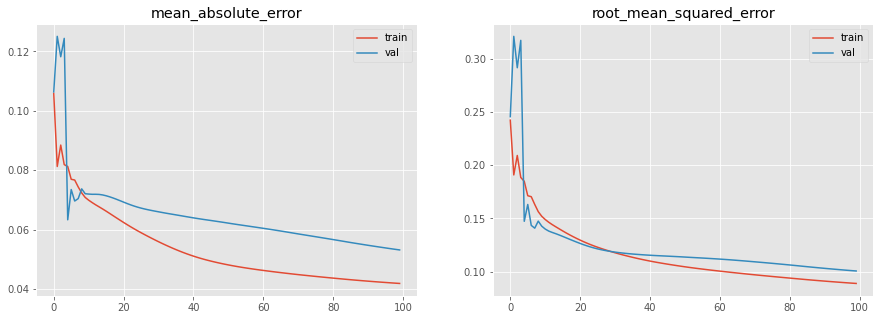

In [6]:
CALLBACKS = [
    EarlyStopping(patience=10),
    tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
    ReduceLROnPlateau(patience=5),
]
opt = Adam(learning_rate=LR)


ffn = make_model(
    N_FEATS, HIDDEN_UNITS, LAYERS, DROPOUT_RATIO, HIDDEN_ACT, OUTPUT_ACT, BATCH_NORM
)


ffn.compile(optimizer=opt, loss=loss_fn, metrics=METRICS)
start = time.time()
history = ffn.fit(
    Xs,
    ys,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT,
    shuffle=False,
    verbose=0,
    callbacks=CALLBACKS,
)
end = time.time()

metrics = ["mean_absolute_error", "root_mean_squared_error"]
fig, ax = plt.subplots(figsize=(15, 5), ncols=2)
for i, metric in enumerate(metrics):
    ax[i].plot(history.history[metric], label="train")
    ax[i].plot(history.history[f"val_{metric}"], label="val")
    ax[i].legend()
    ax[i].set_title(metric)

<AxesSubplot:xlabel='log(S/K)'>

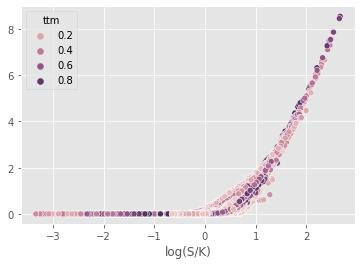

In [7]:
preds = ffn.predict(Xs).reshape(-1)
sns.scatterplot(X_df["log(S/K)"], preds, hue=X_df["ttm"])

Failed to compute gradient errors


<Axes3DSubplot:title={'center':'Surface - standard_ffn'}, xlabel='Moneyness', ylabel='ttm'>

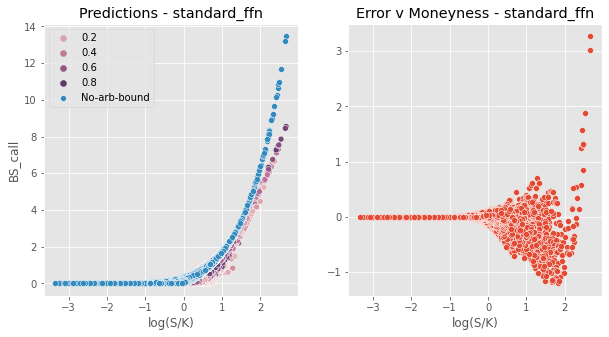

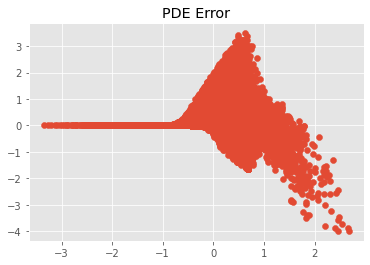

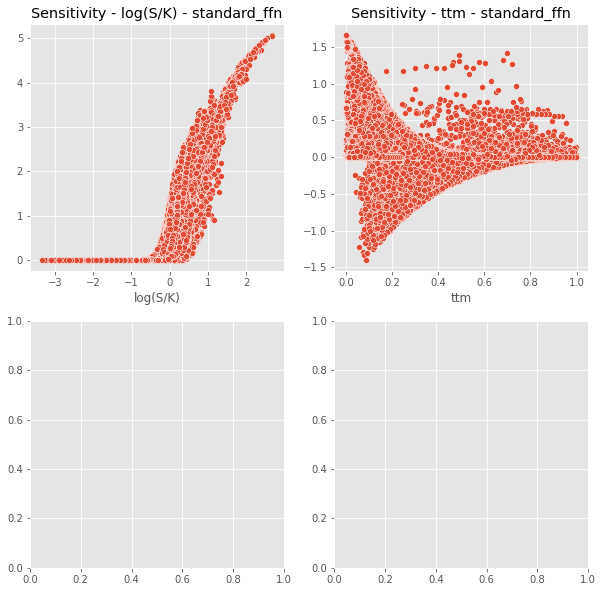

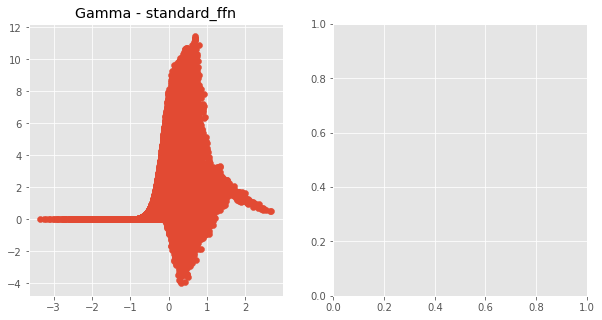

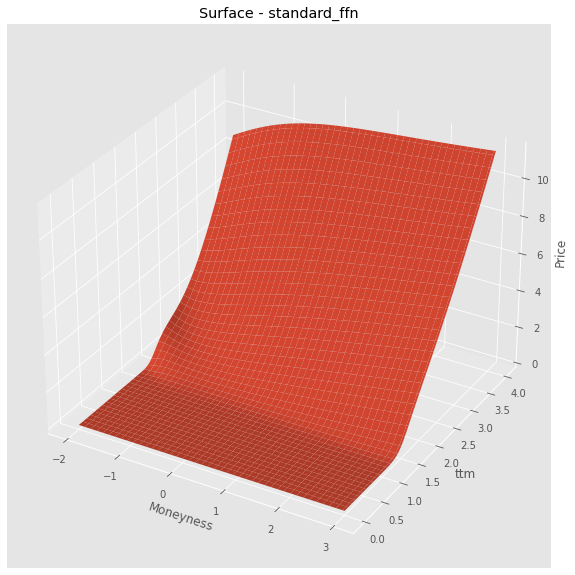

In [8]:
"""
Prediction Errors
"""
model = ffn
start2 = time.time()
preds = model.predict(Xs).reshape(-1)

"""
Compute all Gradients, Hessian
"""

X_tensor = tf.Variable(Xs)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
        output = model(X_tensor)
        grads = tape.gradient(output, X_tensor)
    hessian1 = tape2.gradient(grads[:, f_to_i("log(S/K)")], X_tensor)

grads = grads.numpy()
hessian_moneyness = hessian1.numpy()[:, [0]]
end2 = time.time()

METHOD = "standard_ffn"

temp = bs_eval_wrapper(
    X_df,
    true_val=true.values,
    preds=preds,
    grads=grads,
    hessian_moneyness=hessian_moneyness,
    lower_bound=lower_bound,
    upper_bound=upper_bound,
    METHOD=METHOD,
)
temp["train_time"] = end - start
temp["inference_time"] = end2 - start2

all_res += [temp.copy()]

"""
Visualise call surface
"""
X2[:, 2] = 0.1
visualise_surface(SK, ts, model(X2).numpy(), title=f"Surface - {METHOD}")

In [9]:
# hedging errors
METHOD = "standard_ffn"
X_df[f"{METHOD}_grad"] = grads[:, 0]
X_df["S/K"] = np.exp(X_df["log(S/K)"])
X_df[f"{METHOD}_pnl"] = (
    X_df.groupby("path")["S/K"].diff(-1)
    * np.exp(-X_df["log(S/K)"])
    * X_df[f"{METHOD}_grad"]
)
X_df[f"{METHOD}_pred"] = preds
ffn_pnl = (
    X_df.groupby("path")[f"{METHOD}_pnl"].sum()
    + X_df.groupby("path")[f"{METHOD}_pred"].nth(0)
    - X_df.groupby("path").mean()["barrier_call_payoff"]
)

X_df[f"{METHOD}_grad_ttm"] = grads[:, 1]
explained_pnl_ffn = X_df.groupby("path")[f"{METHOD}_pred"].diff(1) - (
    X_df[f"{METHOD}_grad"] * X_df.groupby("path")["log(S/K)"].diff(-1)
    + X_df[f"{METHOD}_grad_ttm"] * X_df.groupby("path")["ttm"].diff(-1)
)

# Gated Network

Training:   0%|                                        0/100 ETA: ?s,  ?epochs/s

275.8662750720978


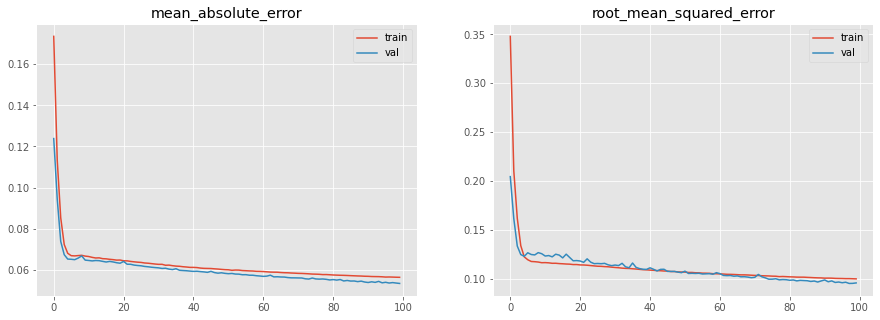

In [10]:
CALLBACKS = [
    EarlyStopping(patience=10),
    tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
]
opt = Adam(learning_rate=LR)

gated_model = homogeneity_network(N_FEATS, HIDDEN_UNITS, seed=42)
gated_model.compile(optimizer=opt, loss=loss_fn, metrics=METRICS)
start = time.time()
history = gated_model.fit(
    [Xs[:, 0], Xs[:, 1], Xs[:, 2]],
    ys,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT,
    verbose=0,
    shuffle=True,
    callbacks=CALLBACKS,
)
end = time.time()
print(end - start)

fig, ax = plt.subplots(figsize=(15, 5), ncols=2)
for i, metric in enumerate(metrics):
    ax[i].plot(history.history[metric], label="train")
    ax[i].plot(history.history[f"val_{metric}"], label="val")
    ax[i].legend()
    ax[i].set_title(metric)

Failed to compute gradient errors


<Axes3DSubplot:title={'center':'Surface - gated_network'}, xlabel='Moneyness', ylabel='ttm'>

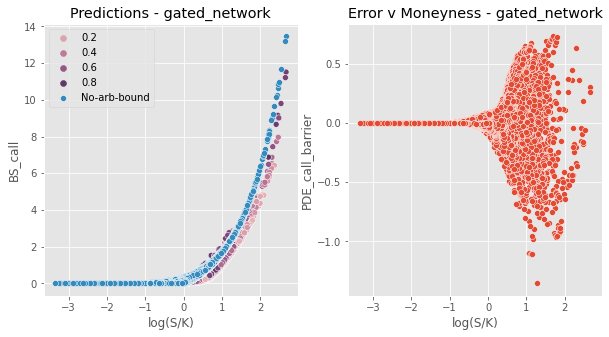

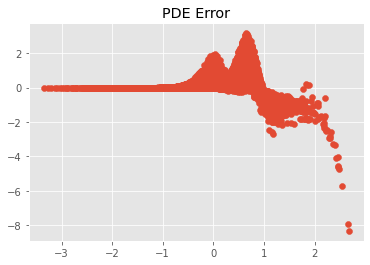

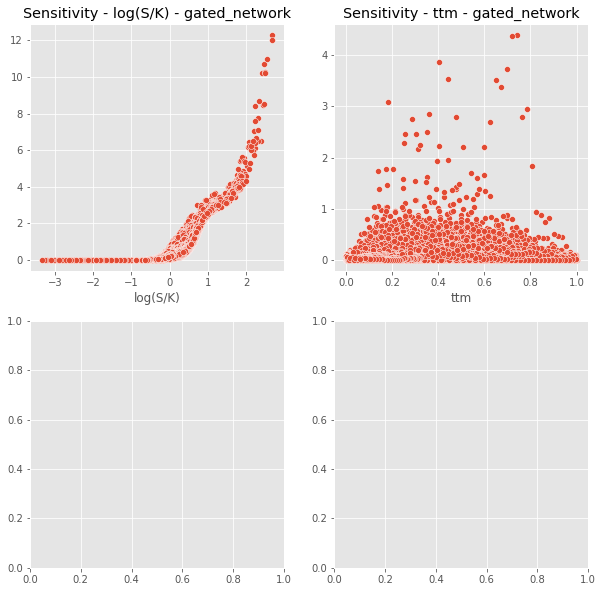

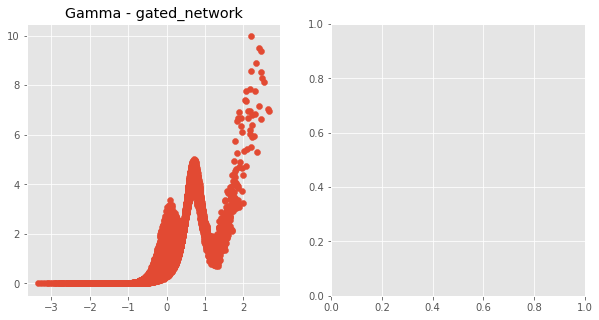

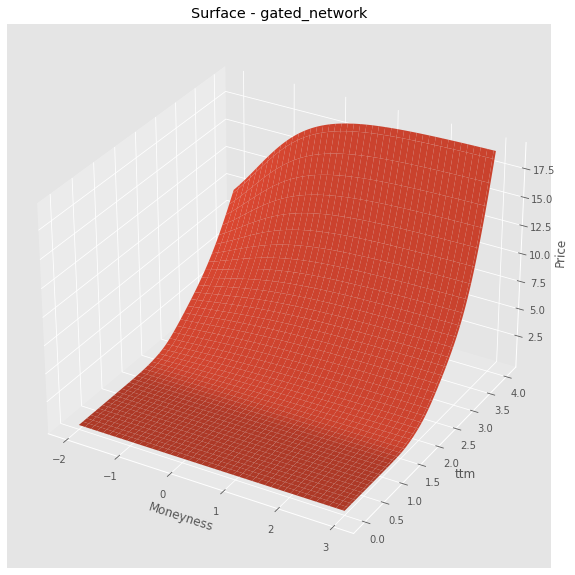

In [11]:
start2 = time.time()
preds = (gated_model.predict([Xs[:, 0], Xs[:, 1], Xs[:, 2]]).reshape(-1)).reshape(-1)

"""
Compute all Gradients, Hessian
"""

X_tensor = tf.Variable(Xs)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
        output = gated_model([X_tensor[:, 0], X_tensor[:, 1], X_tensor[:, 2]])
        grads = tape.gradient(output, X_tensor)
    hessian1 = tape2.gradient(grads[:, f_to_i("log(S/K)")], X_tensor)

grads = grads.numpy()
hessian_moneyness = hessian1.numpy()[:, [0]]
end2 = time.time()

METHOD = "gated_network"
temp = bs_eval_wrapper(
    X_df,
    true_val=true,
    preds=preds,
    grads=grads,
    hessian_moneyness=hessian_moneyness,
    lower_bound=lower_bound,
    upper_bound=upper_bound,
    METHOD=METHOD,
)
temp["train_time"] = end - start
temp["inference_time"] = end2 - start2
all_res += [temp.copy()]

"""
Visualise call surface
"""
SK = np.linspace(-2, 3, 128)
ts = np.linspace(0, 4, 128)
X = np.array(list(product(SK, ts)))
X2 = np.zeros((X.shape[0], N_FEATS))
X2[:, :2] = X
X2[:, 2] = 0.1
visualise_surface(
    SK,
    ts,
    gated_model([X2[:, 0], X2[:, 1], X2[:, 2]]).numpy(),
    title=f"Surface - {METHOD}",
)

In [12]:
METHOD = "gated_network"
X_df[f"{METHOD}_grad"] = grads[:, 0]
X_df[f"{METHOD}_pnl"] = (
    X_df.groupby("path")["S/K"].diff(-1)
    * np.exp(-X_df["log(S/K)"])
    * X_df[f"{METHOD}_grad"]
)
X_df[f"{METHOD}_pred"] = preds
gated_pnl = (
    X_df.groupby("path")[f"{METHOD}_pnl"].sum()
    + X_df.groupby("path")[f"{METHOD}_pred"].nth(0)
    - X_df.groupby("path").mean()["barrier_call_payoff"]
)


X_df[f"{METHOD}_grad_ttm"] = grads[:, 1]
explained_pnl_gated = X_df.groupby("path")[f"{METHOD}_pred"].diff(1) - (
    X_df[f"{METHOD}_grad"] * X_df.groupby("path")["log(S/K)"].diff(-1)
    + X_df[f"{METHOD}_grad_ttm"] * X_df.groupby("path")["ttm"].diff(-1)
)

# FFN + Neural PDE

  0%|          | 0/100 [00:00<?, ?it/s]

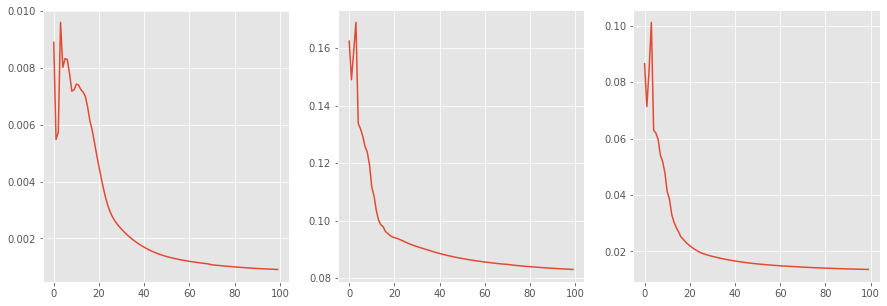

In [13]:
opt = Adam(learning_rate=LR)

dataset = tf.data.Dataset.from_tensor_slices((Xs, ys))
opt = Adam(learning_rate=LR)
model = make_model(
    N_FEATS, HIDDEN_UNITS, LAYERS, DROPOUT_RATIO, HIDDEN_ACT, OUTPUT_ACT, BATCH_NORM
)

batched_dataset = dataset.batch(BATCH_SIZE)
l1, l2 = 1, 1


@tf.function
def train(y, x_var):
    with tf.GradientTape() as model_tape:
        with tf.GradientTape() as hessian_tape:
            with tf.GradientTape() as grad_tape:
                output = model(x_var)
            gradients = grad_tape.gradient(output, x_var)
            hessian = hessian_tape.gradient(gradients[:, 0], x_var)
            pde_loss = tf.math.reduce_mean(
                (gradients[:, 1] + x_var[:, 1] * (-hessian[:, 0] + gradients[:, 0]))
                ** 2
            )
            pred_loss = tf.keras.losses.MeanSquaredError()(output, y)
            loss = l1 * pde_loss + l2 * pred_loss
            model_grad = model_tape.gradient(loss, model.trainable_variables)
            opt.apply_gradients(zip(model_grad, model.trainable_variables))
    return loss, pred_loss, pde_loss


losses = {
    "pde": [None for _ in range(EPOCHS)],
    "loss": [None for _ in range(EPOCHS)],
    "pred": [None for _ in range(EPOCHS)],
}
start = time.time()
for epoch in tqdm(range(EPOCHS)):
    temp_pred = []
    temp_pde = []
    temp_loss = []
    for step, (x, y_true) in enumerate(batched_dataset):
        x_var = tf.Variable(x)
        loss, pred_loss, pde_loss = train(y_true, x_var)
        temp_pred += [np.sqrt(pred_loss.numpy())]
        temp_pde += [pde_loss.numpy()]
        temp_loss += [loss.numpy()]
    losses["pde"][epoch] = np.mean(temp_pde)
    losses["pred"][epoch] = np.mean(temp_pred)
    losses["loss"][epoch] = np.mean(temp_loss)
end = time.time()

fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].plot(losses["pde"])
ax[1].plot(losses["pred"])
ax[2].plot(losses["loss"])

Failed to compute gradient errors


<Axes3DSubplot:title={'center':'Surface'}, xlabel='Moneyness', ylabel='ttm'>

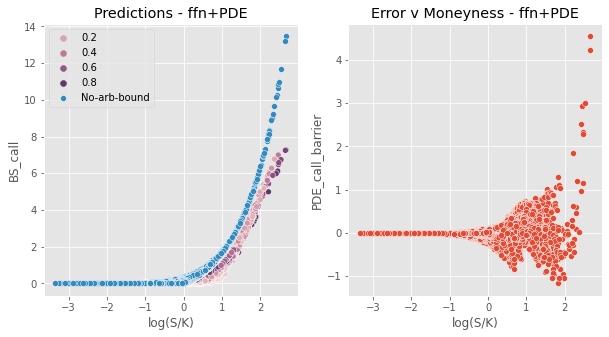

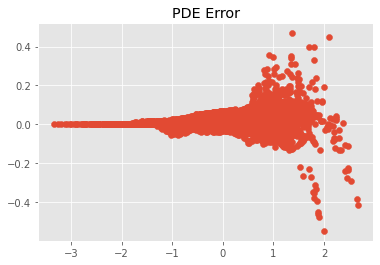

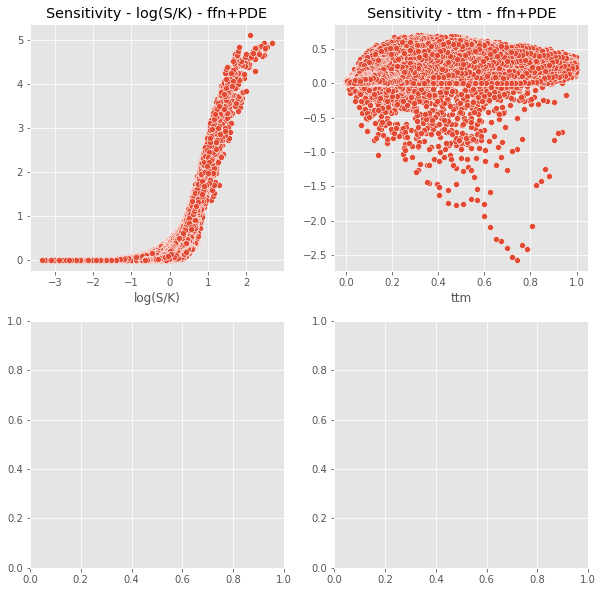

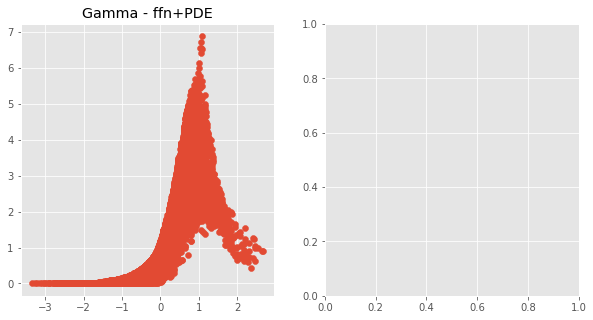

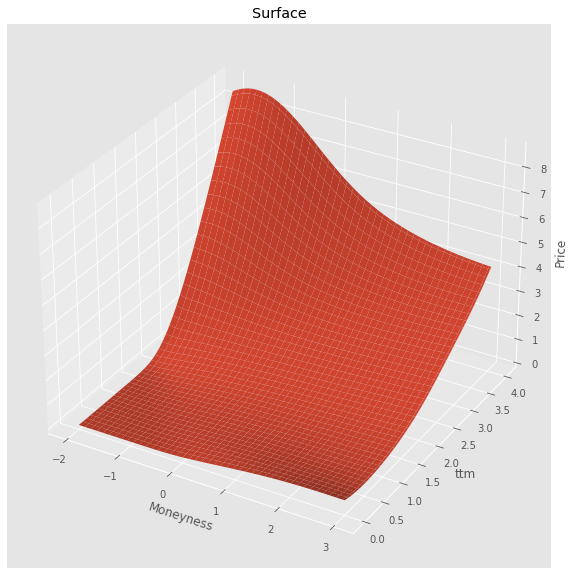

In [14]:
start2 = time.time()
preds = model.predict(Xs).reshape(-1)
"""
Compute all Gradients, Hessian
"""

X_tensor = tf.Variable(Xs)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
        output = model(X_tensor)
        grads = tape.gradient(output, X_tensor)
    hessian1 = tape2.gradient(grads[:, f_to_i("log(S/K)")], X_tensor)

grads = grads.numpy()
hessian_moneyness = hessian1.numpy()[:, [0]]
end2 = time.time()
METHOD = "ffn+PDE"
temp = bs_eval_wrapper(
    X_df,
    true_val=true,
    preds=preds,
    grads=grads,
    hessian_moneyness=hessian_moneyness,
    lower_bound=lower_bound,
    upper_bound=upper_bound,
    METHOD=METHOD,
)
temp["train_time"] = end - start
temp["inference_time"] = end2 - start2
all_res += [temp.copy()]

"""
Visualise call surface
"""
SK = np.linspace(-2, 3, 128)
ts = np.linspace(0, 4, 128)
X = np.array(list(product(SK, ts)))
X2 = np.zeros((X.shape[0], N_FEATS))
X2[:, :2] = X
X2[:, 2] = 0.1
visualise_surface(SK, ts, model(X2).numpy())

In [15]:
METHOD = "ffn+PDE"
X_df[f"{METHOD}_grad"] = grads[:, 0]
X_df[f"{METHOD}_pnl"] = (
    X_df.groupby("path")["S/K"].diff(-1)
    * np.exp(-X_df["log(S/K)"])
    * X_df[f"{METHOD}_grad"]
)
X_df[f"{METHOD}_pred"] = preds
pde_pnl = (
    X_df.groupby("path")[f"{METHOD}_pnl"].sum()
    + X_df.groupby("path")[f"{METHOD}_pred"].nth(0)
    - X_df.groupby("path").mean()["barrier_call_payoff"]
)

X_df[f"{METHOD}_grad_ttm"] = grads[:, 1]
explained_pnl_pde = X_df.groupby("path")[f"{METHOD}_pred"].diff(1) - (
    X_df[f"{METHOD}_grad"] * X_df.groupby("path")["log(S/K)"].diff(-1)
    + X_df[f"{METHOD}_grad_ttm"] * X_df.groupby("path")["ttm"].diff(-1)
)

Failed to compute gradient errors


<Axes3DSubplot:title={'center':'Surface - ffn+PDE'}, xlabel='Moneyness', ylabel='ttm'>

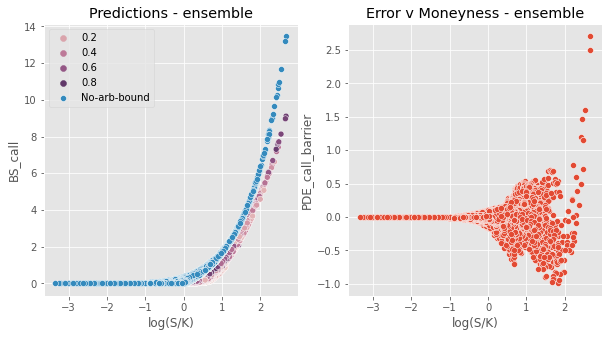

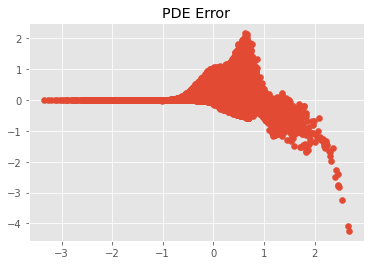

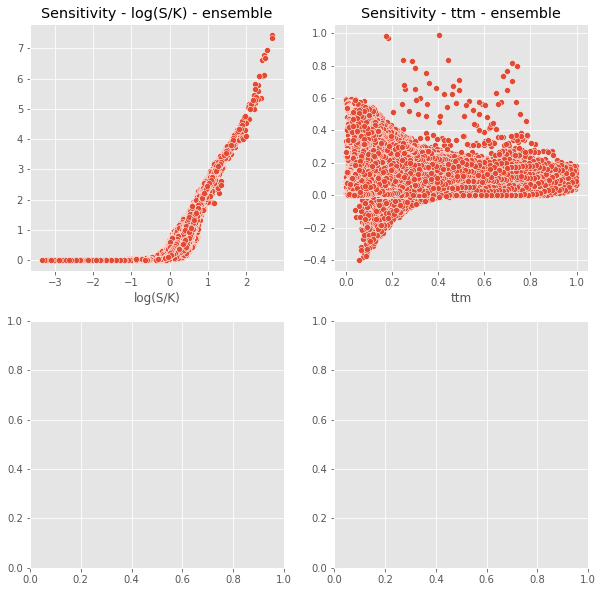

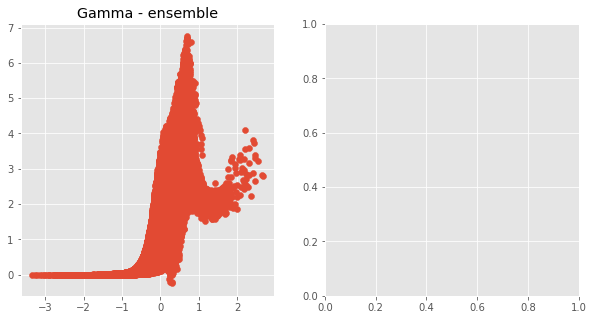

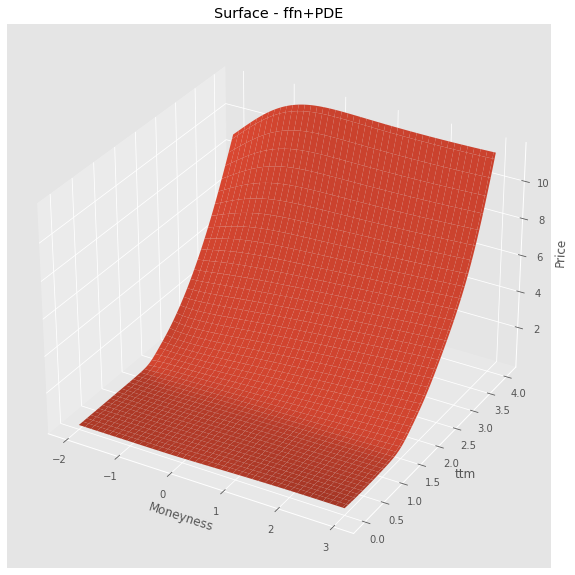

In [16]:
preds = (
    model.predict(Xs).reshape(-1)
    + ffn.predict(Xs).reshape(-1)
    + gated_model.predict([Xs[:, 0], Xs[:, 1], Xs[:, 2]]).reshape(-1)
) / 3
"""
Compute all Gradients, Hessian
"""

X_tensor = tf.Variable(Xs)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
        output = model(X_tensor)
        grads = tape.gradient(output, X_tensor)
    hessian1 = tape2.gradient(grads[:, f_to_i("log(S/K)")], X_tensor)


X_tensor = tf.Variable(Xs)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
        output = ffn(X_tensor)
        grads_ffn = tape.gradient(output, X_tensor)
    hessian1_ffn = tape2.gradient(grads_ffn[:, f_to_i("log(S/K)")], X_tensor)

X_tensor = tf.Variable(Xs)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
        output = gated_model([X_tensor[:, 0], X_tensor[:, 1], X_tensor[:, 2]])
        grads_gated = tape.gradient(output, X_tensor)
    hessian1_gated = tape2.gradient(grads_gated[:, f_to_i("log(S/K)")], X_tensor)

grads = (grads.numpy() + grads_gated.numpy() + grads_ffn.numpy()) / 3
hessian_moneyness = (
    hessian1.numpy()[:, [0]]
    + hessian1_gated.numpy()[:, [0]]
    + hessian1_ffn.numpy()[:, [0]]
) / 3

temp = bs_eval_wrapper(
    X_df,
    true_val=true,
    preds=preds,
    grads=grads,
    hessian_moneyness=hessian_moneyness,
    lower_bound=lower_bound,
    upper_bound=upper_bound,
    METHOD="ensemble",
)
temp["train_time"] = end - start
all_res += [temp.copy()]

"""
Visualise call surface
"""
SK = np.linspace(-2, 3, 128)
ts = np.linspace(0, 4, 128)
X = np.array(list(product(SK, ts)))
X2 = np.zeros((X.shape[0], N_FEATS))
X2[:, :2] = X
X2[:, 2] = 0.1
surf = (
    ffn(X2).numpy()
    + model(X2).numpy()
    + gated_model([X2[:, 0], X2[:, 1], X2[:, 2]]).numpy()
) / 3
visualise_surface(SK, ts, surf, title=f"Surface - {METHOD}")

# Statistics

In [22]:
all_res_df = pd.concat(all_res).T
all_res_df = (
    all_res_df.T.reset_index()
    .drop_duplicates(subset=["index"], keep="last")
    .set_index("index")
    .T
)
all_res_df.loc["train_time", "ensemble"] = all_res_df.T["train_time"].iloc[:3].sum()
all_res_df.loc["inference_time", "ensemble"] = (
    all_res_df.T["inference_time"].iloc[:3].sum()
)
all_res_df.dropna().style.background_gradient(axis=1)

index,standard_ffn,gated_network,ffn+PDE,ensemble
pred_l1,0.055445,0.055607,0.058462,0.045564
pred_l2,0.108316,0.099111,0.108553,0.086135
pred_l_inf,3.266479,1.354548,4.540387,2.703017
pred_upper_bound_violation,0.200228,0.268457,0.276383,0.262061
PDE_mean,0.259488,0.201454,0.004205,0.155049
PDE_l1,0.376099,0.248714,0.015285,0.202057
PDE_l2,0.622287,0.451882,0.024421,0.332657
PDE_l_inf,3.984750,8.328815,0.546851,4.241702
monotonicity_error,0.000000,0.000000,0.000000,0.000000
time_value_error,0.186328,0.000000,0.013005,0.016488


,ffn,gated,ffn+PDE,ensemble
mean_pnl,-0.115168,-0.123449,-0.076466,-0.105028
l1,0.544153,0.457693,0.468072,0.488905
l2,1.212760,1.133484,1.076436,1.137058
linf,17.460850,17.914972,16.074780,17.150201
skew,-5.173535,-6.070381,-5.707989,-5.665150
kurtosis,43.591403,57.361128,50.914295,50.631458
CVaR_10,2.831512,2.573950,2.414044,2.602065
CVaR_5,4.126596,3.933585,3.660974,3.899714
CVaR_2,6.257265,6.141487,5.756973,6.050629
CVaR_1,7.970879,7.869963,7.369737,7.711927


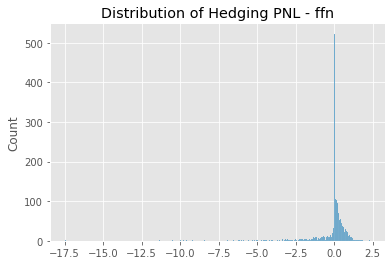

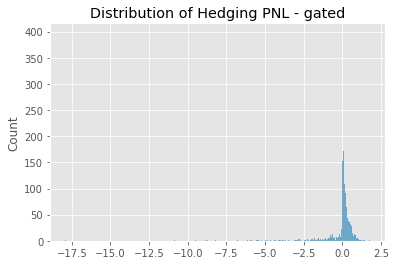

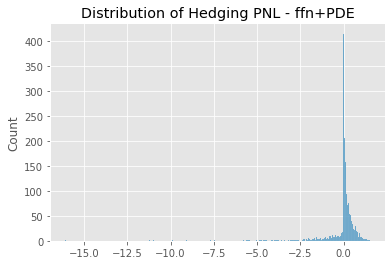

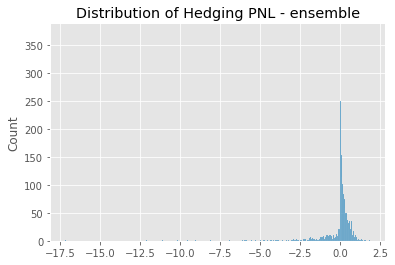

In [23]:
# hedging PNL statistics
hedge_table = pd.concat(
    [
        diagnosis_hedge(ffn_pnl, "ffn"),
        diagnosis_hedge(gated_pnl, "gated"),
        diagnosis_hedge(pde_pnl, "ffn+PDE"),
        diagnosis_hedge((ffn_pnl + gated_pnl + pde_pnl) / 3, "ensemble"),
    ]
)


hedge_table.T.style.background_gradient(axis=1)

,ffn,gated,ffn+PDE,ensemble
mean_pnl,-0.000194,-0.001372,-0.005227,-0.002265
l1,0.066051,0.050376,0.049287,0.055141
l2,0.154789,0.137971,0.120189,0.135561
linf,2.875201,4.259625,2.896028,3.117582
skew,0.633220,0.618118,0.963126,0.735268
kurtosis,30.247475,76.731561,52.462817,46.908977
CVaR_10,0.259723,0.206536,0.199577,0.219612
CVaR_5,0.380168,0.321137,0.293919,0.327464
CVaR_2,0.567238,0.524429,0.449404,0.506197
CVaR_1,0.728704,0.711719,0.589664,0.666385


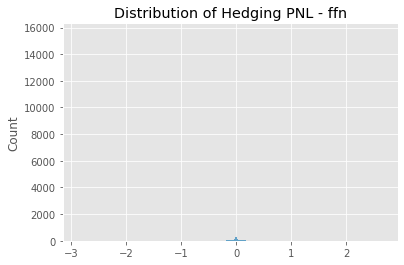

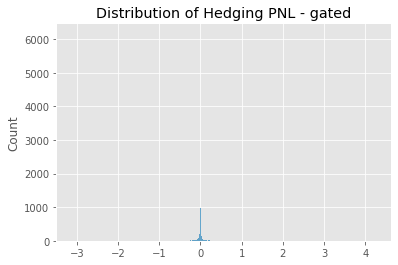

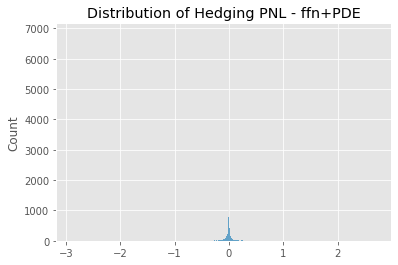

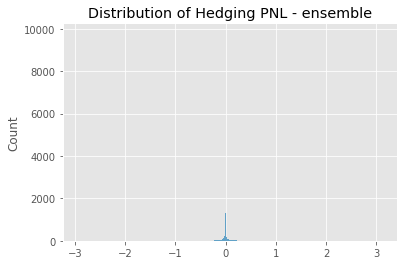

In [21]:
# hedging PNL statistics
hedge_table = pd.concat(
    [
        diagnosis_hedge(explained_pnl_ffn.dropna(), "ffn"),
        diagnosis_hedge(explained_pnl_gated.dropna(), "gated"),
        diagnosis_hedge(explained_pnl_pde.dropna(), "ffn+PDE"),
        diagnosis_hedge(
            (explained_pnl_ffn + explained_pnl_gated + explained_pnl_pde).dropna() / 3,
            "ensemble",
        ),
    ]
)


hedge_table.T.style.background_gradient(axis=1)

In [20]:
# temp = X_df.loc[X_df['error'].abs() < 0.001, ['log(S/K)','ttm','b']]

# pd.concat([temp.loc[temp[i].idxmin()] for i in ['log(S/K)','ttm','b']] + [temp.loc[temp[i].idxmax()] for i in ['log(S/K)','ttm','b']], axis =1).T
# X_df['error'] = X_df['PDE_call_barrier'] - X_df['ffn+PDE_pred']
# constraints = X_df.loc[X_df['error'].abs() < 0.001, ['log(S/K)','ttm','b']].describe().loc[['min','max']]
# # valid = ((X_df['log(S/K)'].between(constraints.loc['min', 'log(S/K)'], constraints.loc['max', 'log(S/K)']))
# # * (X_df['ttm'].between(constraints.loc['min', 'ttm'], constraints.loc['max', 'ttm'])) *
# # (X_df['b'].between(constraints.loc['min', 'b'], constraints.loc['max', 'b'])))
# # X_df.loc[valid, 'error']
# constraints